In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from datetime import date
today_for_api  = str(date.today())
import pandas as pd
import numpy as np
#######图形模版
import seaborn as sns
cm=sns.color_palette("Spectral", as_cmap=True)
#cm = sns.light_palette("Spectral", as_cmap=True)
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
font = ['Songti SC']
parameters = {'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          "font.family" : "sans-serif",
          "font.sans-serif":font,
          'font.size':15,
          "axes.unicode_minus":False}
plt.rcParams.update(parameters)

/var/folders/bg/h2_d2l2939102wvpkt70y0_00000gn/T/ipykernel_4491/3603077383.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")


In [6]:
import pickle
f2 = open('temp.pkl', 'rb')  
macro_data = pickle.load(f2)  
macro_zscore = pickle.load(f2)  
index_orig = pickle.load(f2)  
index_transformer = pickle.load(f2)  
df_fund = pickle.load(f2)  
df_fund.index=df_fund.index.to_period("M")
f2.close() 

df_ret_ratio=index_orig

# 基于月度数据夏普估计：夏普方法2

#Whitelaw（1997）


index_sharpe=index_orig

df_ret_ratio_mean_monthly=index_sharpe.resample("M").sum()
df_ret_ratio_std_monthly=np.sqrt((df_ret_ratio**2).resample("M").sum())
df_sharpe =df_ret_ratio_mean_monthly/df_ret_ratio_std_monthly

df_sharpe.mean()


MSCI中国A股(人民币)          0.155037
MSCI中国A股在岸低波(人民币)      0.205786
MSCI中国A股在岸公司质量(人民币)    0.225771
MSCI中国A股在岸价值(人民币)      0.124020
MSCI中国A股在岸成长(人民币)      0.162680
MSCI中国A股在岸中小盘(人民币)     0.202491
MSCI中国A股在岸动能(人民币)      0.156768
dtype: float64

In [7]:
import arviz as az
import pymc as pm
import aesara.tensor as at
#import recombinator

from recombinator.block_bootstrap import circular_block_bootstrap

y_star_cb   = circular_block_bootstrap(df_sharpe, 
                               block_length=36, 
                               replications=500, 
                               replace=True)




IR_estimate_from_bootstrap = np.zeros((500,np.shape(y_star_cb)[2]))
for b in range(500):
       IR_estimate_from_bootstrap[b,:] =  np.mean(y_star_cb[b,:,:],axis=0)
IR_mean=IR_estimate_from_bootstrap.mean(axis=0)

IR_sample_std=IR_estimate_from_bootstrap.std(axis=0)

model_begin_date="2012-09-01"

index_transformer_month= index_transformer.resample("M").sum()



df_data = pd.DataFrame(columns = ["Period"]).set_index("Period")
date_model =pd.date_range(start=model_begin_date,end="2022-09-01",freq="M").to_period("M")
df_data.index=date_model
df_data["Test_"] = "True"



df_macro_filter = pd.concat([df_data,macro_zscore.shift(3)],axis=1).query('Test_=="True"')
df_macro_filter_predict = pd.concat([df_data,macro_zscore],axis=1).query('Test_=="True"')

df_Factor_filter=pd.concat([df_data,index_transformer_month],axis=1).query('Test_=="True"')
data_alpha_filter =pd.concat([df_data,df_fund],axis=1).query('Test_=="True"')
data_alpha_filter= data_alpha_filter.dropna(axis=1)

data_total =pd.concat([df_Factor_filter.drop("Test_",axis=1),data_alpha_filter.drop("Test_",axis=1)],axis=1).T


Df_macro = df_macro_filter.drop("Test_",axis=1).T
Df_macro_predict = df_macro_filter_predict.drop("Test_",axis=1).T


Df_Factor=(df_Factor_filter.drop("Test_",axis=1).T)*12
Df_alpha=(data_alpha_filter.drop("Test_",axis=1).T)*12
prior_mu = np.array([x for x in IR_mean])
prior_std = np.array([x for x in IR_sample_std])




In [229]:
data_alpha_filter.mean()*12

交银趋势混合A              0.222128
浦银安盛精致生活混合           0.141122
景顺长城中小盘混合            0.111626
金鹰红利价值混合A            0.142041
南方上证380ETF联接A        0.089805
金鹰中小盘精选混合            0.112599
融通内需驱动混合A/B          0.131383
国泰价值经典灵活配置混合(LOF)    0.166547
国泰金鹰增长灵活配置混合         0.149869
华夏盛世混合               0.077170
dtype: float64

In [8]:
RANDOM_SEED = 8924
Df_model_example = Df_macro.head(1)

macro_dim =Df_model_example.shape[0]

fund_dim= Df_Factor.shape[0]

model_dim =data_total.shape[0]

model_dim_T=date_model.shape[0]
alpha_mean__prior =0.36
alpha_std__prior =0.17
LKJ_eta__prior =3
LKJ_st__prior =1.0
LKJ_st_prior =1.0
T_len=model_dim_T
__Df_alpha_model=Df_alpha
alpha_len = __Df_alpha_model.shape[0]

In [160]:
__Df_alpha_model.std(axis=1)

交银趋势混合A              0.849092
浦银安盛精致生活混合           1.121234
景顺长城中小盘混合            0.904444
金鹰红利价值混合A            0.592971
南方上证380ETF联接A        0.821023
金鹰中小盘精选混合            0.775092
融通内需驱动混合A/B          0.871681
国泰价值经典灵活配置混合(LOF)    0.879854
国泰金鹰增长灵活配置混合         0.867906
华夏盛世混合               0.963237
dtype: float64

In [10]:
fund_dim= Df_Factor.shape[0]

model_dim =data_total.shape[0]

model_dim_T=date_model.shape[0]

In [ ]:

for i in Df_macro.index:
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
    Df_model_example = Df_macro.loc[[i]]
    
    macro_dim =Df_model_example.shape[0]
    coords_test = {"Fund": Df_Factor.index.values, "date":data_total.columns.to_timestamp().astype("int"),"macro":Df_model_example.index.values,"Alpha":__Df_alpha_model.index.values}
    s="""with pm.Model(coords=coords_test) as {}:
        sharpe_ratio= pm.Normal("μ", prior_mu.T, prior_std, dims=("Fund"))
        sharpe_ratio=at.reshape(sharpe_ratio,(fund_dim,1))
        beta = pm.Normal("beta", mu=0, sigma=20,shape=(fund_dim,macro_dim),dims=("Fund","macro"))
        data_macro = pm.Data("data", Df_model_example.values.astype(float),mutable=True,dims=("macro","date"))
        sharpe_ratio_t = pm.Deterministic("SR_t",at.tile(sharpe_ratio,(1,model_dim_T)) + at.dot(beta,data_macro),dims=("Fund","date"))
        #sd_dist=pm.Exponential("std",1.0,shape=6,dims=("Fund"))
        sd_dist=pm.Exponential("std",1.0,shape=fund_dim,dims=("Fund"))
        sd_dist= at.reshape(sd_dist,(fund_dim,1))
        sd_T =at.tile(sd_dist,(1,model_dim_T)) 
        obs = pm.Normal("obs",mu=sharpe_ratio_t*sd_dist,sigma=sd_dist,observed=Df_Factor,dims=("Fund", "date"))


        ############################################
        ############################################
        ###############################################
        ############################################
        factor_loading = pm.Normal("factor_loading", mu=0, sigma=2,shape=fund_dim,dims=("Fund"))
        factor_loading= at.reshape(factor_loading,(fund_dim,1))


        factor_loading_T =at.tile(factor_loading,(1,T_len))                         
        factor_loading_T=factor_loading_T*sharpe_ratio_t                
        factor_loading_sum= factor_loading_T.sum(axis=0)
        factor_loading_sum =at.reshape(factor_loading_sum,(1,T_len)) 
        factor_loading_sum_stack=at.tile(factor_loading_sum,(alpha_len,1))  

        alpha = pm.Normal("μ_alpha",alpha_mean__prior, alpha_std__prior)
        alpha_n = pm.Normal("IC_alpha",alpha,sigma=1,shape=alpha_len,dims=("Alpha"))
        alpha_n= at.reshape(alpha_n,(alpha_len,1))


        IC_alpha_t = pm.Deterministic("SR_alpha_t",at.tile(alpha_n,(1,T_len)) + factor_loading_sum_stack,dims=("Alpha","date"))

        chol, corr, stds = pm.LKJCholeskyCov(
            "chol", n=alpha_len, eta=LKJ_eta__prior, sd_dist=pm.Exponential.dist(LKJ_st__prior), compute_corr=True
        )






        __stds =  at.reshape(stds,(alpha_len,1)) 
        __stds_t = at.tile(__stds,(1,T_len)) 

        T_n_cov =np.eye(T_len)

        obs_sharpe=pm.MatrixNormal('_IC', mu=IC_alpha_t*__stds_t, rowchol=chol,colcov=T_n_cov,observed=__Df_alpha_model.values,dims=("Alpha","date"))

    
    """.format(model_name)
    exec(s)



    RANDOM_SEED = 8924
    h="""with {}:
        {} = pm.sample(draws=2000,random_seed=RANDOM_SEED, init="advi",chains=2,n_init=500, tune=500,target_accept=0.8,return_inferencedata=True)
    """.format(model_name,result_name)
    exec(h)
    Df_macro_example_predict = Df_macro_predict.loc[[i]]
    e="""with {}:
        pm.set_data({{"data": Df_macro_example_predict.values.astype(float)}})
        {} = pm.sample_posterior_predictive(
            {},
        var_names=["SR_t","obs","_IC"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )""".format(model_name,result_name,result_name)
    exec(e)
#__Df_alpha_fit_data_model=__Df_alpha_model.values[~np.isnan(__Df_alpha_model.values)]
#alpha_fit_variable = obs_sharpe[~np.isnan(__Df_alpha_model.values)]
#obss=pm.Normal("_IC",alpha_fit_variable,sigma=0.00001,observed=__Df_alpha_fit_data_model)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 3.5455e+05
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 720 seconds.
Sampling: [_IC, obs]


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 3.6815e+05
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 659 seconds.
Sampling: [_IC, obs]


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 3.5227e+05
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 652 seconds.
Sampling: [_IC, obs]


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 3.2921e+05
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol]


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

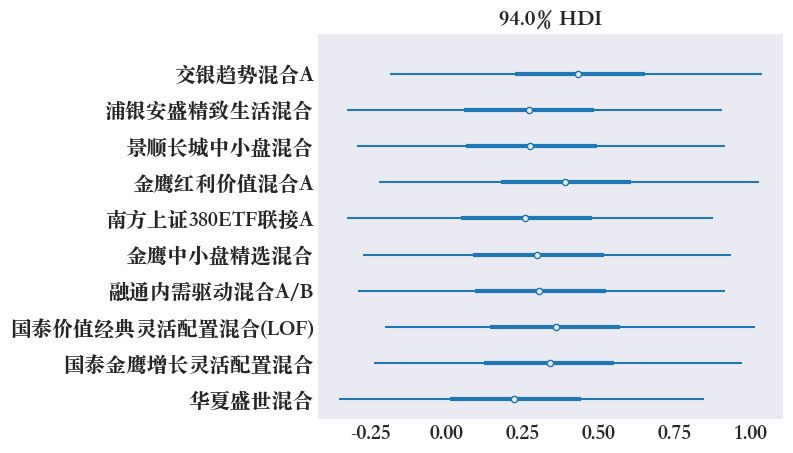

In [14]:
 az.plot_forest(
    trace_alpha_total_bm,
    var_names=["IC_alpha"],
    #kind="ridgeplot",
    combined=True,
    coords={"Alpha":__Df_alpha_model.index.values},
    labeller=az.labels.NoVarLabeller(),
)
    
#     traces=[]
# for i in Df_macro.index:

#     result_name = "trace_alpha_total_"+i
#     traces.append(result_name)
    


## trace数据保存

In [7]:
# for i in Df_macro.index:
#     files="trace_{}.nc".format(i)
#     s="""trace_alpha_total_{}.to_netcdf('{}')""".format(i,files)
#     exec(s)
    

    

#trace_alpha_total_dp.to_netcdf("trace_dp.nc")

# 数据读入（从数据保存：二次运行）

In [13]:
for i in Df_macro.index:
    files="trace_{}.nc".format(i)
    s="""trace_alpha_total_{}= az.from_netcdf('{}')""".format(i,files)
    exec(s)

In [27]:

for i in Df_macro.index:
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
    Df_model_example = Df_macro.loc[[i]]
    
    macro_dim =Df_model_example.shape[0]
    coords_test = {"Fund": Df_Factor.index.values, "date":data_total.columns.to_timestamp().astype("int"),"macro":Df_model_example.index.values,"Alpha":__Df_alpha_model.index.values}
    s="""with pm.Model(coords=coords_test) as {}:
        sharpe_ratio= pm.Normal("μ", prior_mu.T, prior_std, dims=("Fund"))
        sharpe_ratio=at.reshape(sharpe_ratio,(fund_dim,1))
        beta = pm.Normal("beta", mu=0, sigma=20,shape=(fund_dim,macro_dim),dims=("Fund","macro"))
        data_macro = pm.Data("data", Df_model_example.values.astype(float),mutable=True,dims=("macro","date"))
        sharpe_ratio_t = pm.Deterministic("SR_t",at.tile(sharpe_ratio,(1,model_dim_T)) + at.dot(beta,data_macro),dims=("Fund","date"))
        #sd_dist=pm.Exponential("std",1.0,shape=6,dims=("Fund"))
        sd_dist=pm.Exponential("std",1.0,shape=fund_dim,dims=("Fund"))
        sd_dist= at.reshape(sd_dist,(fund_dim,1))
        sd_T =at.tile(sd_dist,(1,model_dim_T)) 
        obs = pm.Normal("obs",mu=sharpe_ratio_t*sd_dist,sigma=sd_dist,observed=Df_Factor,dims=("Fund", "date"))


        ############################################
        ############################################
        ###############################################
        ############################################
        factor_loading = pm.Normal("factor_loading", mu=0, sigma=2,shape=fund_dim,dims=("Fund"))
        factor_loading= at.reshape(factor_loading,(fund_dim,1))


        factor_loading_T =at.tile(factor_loading,(1,T_len))                         
        factor_loading_T=factor_loading_T*sharpe_ratio_t                
        factor_loading_sum= factor_loading_T.sum(axis=0)
        factor_loading_sum =at.reshape(factor_loading_sum,(1,T_len)) 
        factor_loading_sum_stack=at.tile(factor_loading_sum,(alpha_len,1))  

        alpha = pm.Normal("μ_alpha",alpha_mean__prior, alpha_std__prior)
        alpha_n = pm.Normal("IC_alpha",alpha,sigma=1,shape=alpha_len,dims=("Alpha"))
        alpha_n= at.reshape(alpha_n,(alpha_len,1))


        IC_alpha_t = pm.Deterministic("SR_alpha_t",at.tile(alpha_n,(1,T_len)) + factor_loading_sum_stack,dims=("Alpha","date"))

        chol, corr, stds = pm.LKJCholeskyCov(
            "chol", n=alpha_len, eta=LKJ_eta__prior, sd_dist=pm.Exponential.dist(LKJ_st__prior), compute_corr=True
        )






        __stds =  at.reshape(stds,(alpha_len,1)) 
        __stds_t = at.tile(__stds,(1,T_len)) 

        T_n_cov =np.eye(T_len)

        obs_sharpe=pm.MatrixNormal('_IC', mu=IC_alpha_t*__stds_t, rowchol=chol,colcov=T_n_cov,observed=__Df_alpha_model.values,dims=("Alpha","date"))

    
    """.format(model_name)
    exec(s)



In [28]:
for i in Df_macro.index:
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
    print(i)


dp
dy
ep
de
svar
bm
ntis
tbl
ity
itr
tms
dfy
infl


# BMA

In [29]:
trace_BMA=[trace_alpha_total_dp,
trace_alpha_total_dy,
trace_alpha_total_ep,
trace_alpha_total_de,
trace_alpha_total_svar,
trace_alpha_total_bm,
trace_alpha_total_ntis,
trace_alpha_total_tbl,
trace_alpha_total_ity,
trace_alpha_total_itr,
trace_alpha_total_tms,
trace_alpha_total_dfy,
trace_alpha_total_infl]

In [30]:
model_BMA=[]
for i in Df_macro.index:
    print( "model_total_"+i)
    model_BMA.append("model_total_"+i)

model_total_dp
model_total_dy
model_total_ep
model_total_de
model_total_svar
model_total_bm
model_total_ntis
model_total_tbl
model_total_ity
model_total_itr
model_total_tms
model_total_dfy
model_total_infl


In [33]:
model_dict = dict(zip(model_BMA, trace_BMA))
comp_fund = az.compare(model_dict,ic="loo",method="BB-pseudo-BMA",b_samples=1000,seed=RANDOM_SEED, scale="log",var_name="obs")
comp_alpha = az.compare(model_dict,ic="loo",method="BB-pseudo-BMA",b_samples=1000,seed=RANDOM_SEED, scale="log",var_name="_IC")

/Users/xinyuexu/opt/anaconda3/envs/FOF/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/xinyuexu/opt/anaconda3/envs/FOF/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/xinyuexu/opt/anaconda3/en

## 宏观指标的效力（从因子解释）:对比

In [36]:
import seaborn as sns
cm=sns.color_palette("Spectral", as_cmap=True)
comp_fund.style.background_gradient(cmap=cm)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_total_dfy,0,-425.196047,23.787326,0.000000,0.472321,35.637757,0.000000,False,log
model_total_infl,1,-426.291386,25.557142,1.095339,0.347246,35.460425,5.870951,True,log
model_total_ntis,2,-429.130356,25.395348,3.934310,0.077827,35.201230,5.455329,True,log
model_total_svar,3,-429.603383,23.690622,4.407337,0.040086,35.286266,4.746227,False,log
model_total_ity,4,-430.574827,23.147611,5.378780,0.017062,35.473622,4.563452,True,log
model_total_tbl,5,-430.862115,23.597184,5.666069,0.011422,35.459971,4.728782,True,log
model_total_de,6,-431.578164,24.068776,6.382118,0.006855,34.992301,4.497222,True,log
model_total_tms,7,-432.085986,23.185913,6.889939,0.001789,37.115878,4.446981,True,log
model_total_dy,8,-432.303595,23.500450,7.107548,0.002619,35.222821,4.441793,True,log
model_total_bm,9,-432.838930,24.695204,7.642883,0.002265,35.324370,4.584940,True,log


## 宏观指标的效力（从基金收益率角度）

In [37]:
comp_alpha.style.background_gradient(cmap=cm)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_total_svar,0,-718.585948,35.721044,0.000000,0.450390,0.000000,0.000000,True,log
model_total_de,1,-719.042345,36.265138,0.456397,0.285350,0.000000,0.000000,True,log
model_total_ep,2,-720.116048,33.793839,1.530100,0.097516,0.000000,0.000000,True,log
model_total_dy,3,-720.553207,34.675080,1.967259,0.062982,0.000000,0.000000,True,log
model_total_infl,4,-720.768577,36.361938,2.182629,0.050779,0.000000,0.000000,True,log
model_total_tms,5,-722.002616,35.531722,3.416668,0.014783,0.000000,0.000000,True,log
model_total_dp,6,-722.176849,36.724634,3.590901,0.012419,0.000000,0.000000,True,log
model_total_itr,7,-722.326200,37.617462,3.740252,0.010696,0.000000,0.000000,True,log
model_total_dfy,8,-722.781960,36.994965,4.196012,0.006781,0.000000,0.000000,True,log
model_total_tbl,9,-723.403523,36.698517,4.817575,0.003642,0.000000,0.000000,True,log


In [597]:

weights_fund = comp_fund.loc[model_BMA]["weight"]


In [599]:
weights_alpha = comp_alpha.loc[model_BMA]["weight"]


In [39]:
#az.summary(trace_alpha_total_ep)

In [43]:
az.summary(trace_alpha_total_dp, var_names=["beta"], round_to=2)
az.summary(trace_alpha_total_svar, var_names=["beta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[MSCI中国A股(人民币), svar]",0.05,0.07,-0.09,0.18,0.0,0.0,3626.31,2421.74,1.0
"beta[MSCI中国A股在岸低波(人民币), svar]",0.00,0.07,-0.13,0.14,0.0,0.0,3504.44,2746.79,1.0
"beta[MSCI中国A股在岸公司质量(人民币), svar]",0.06,0.07,-0.07,0.21,0.0,0.0,3811.96,2954.33,1.0
"beta[MSCI中国A股在岸价值(人民币), svar]",-0.14,0.07,-0.29,-0.01,0.0,0.0,3444.85,2772.37,1.0
"beta[MSCI中国A股在岸成长(人民币), svar]",0.10,0.07,-0.03,0.25,0.0,0.0,3455.24,2630.47,1.0
"beta[MSCI中国A股在岸中小盘(人民币), svar]",0.06,0.07,-0.07,0.20,0.0,0.0,3451.51,2828.10,1.0
"beta[MSCI中国A股在岸动能(人民币), svar]",0.07,0.07,-0.07,0.21,0.0,0.0,3634.45,2391.45,1.0


In [611]:
az.summary(trace_alpha_total_de, var_names=["beta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[MSCI中国A股(人民币), de]",-0.11,0.08,-0.26,0.05,0.0,0.0,4126.99,2824.32,1.0
"beta[MSCI中国A股在岸低波(人民币), de]",0.02,0.08,-0.12,0.19,0.0,0.0,3295.13,2401.36,1.0
"beta[MSCI中国A股在岸公司质量(人民币), de]",0.01,0.09,-0.15,0.17,0.0,0.0,3793.19,2828.96,1.0
"beta[MSCI中国A股在岸价值(人民币), de]",0.06,0.08,-0.09,0.21,0.0,0.0,3715.97,2792.57,1.0
"beta[MSCI中国A股在岸成长(人民币), de]",-0.07,0.08,-0.22,0.09,0.0,0.0,3795.40,3062.20,1.0
"beta[MSCI中国A股在岸中小盘(人民币), de]",-0.13,0.08,-0.28,0.02,0.0,0.0,2823.16,2528.95,1.0
"beta[MSCI中国A股在岸动能(人民币), de]",-0.01,0.08,-0.17,0.14,0.0,0.0,3593.18,2552.53,1.0


# weight集成:分布收益率与SR（样本外预测分布）

In [612]:
import xarray as xr
def weight_predictions_return(idatas, weights=None):
    """
    Generate weighted posterior predictive samples from a list of InferenceData
    and a set of weights.
    Parameters
    ---------
    idatas : list[InferenceData]
        List of :class:`arviz.InferenceData` objects containing the groups `posterior_predictive`
        and `observed_data`. Observations should be the same for all InferenceData objects.
    weights : array-like, optional
        Individual weights for each model. Weights should be positive. If they do not sum up to 1,
        they will be normalized. Default, same weight for each model.
        Weights can be computed using many different methods including those in
        :func:`arviz.compare`.
    Returns
    -------
    idata: InferenceData
        Output InferenceData object with the groups `posterior_predictive` and `observed_data`.
    See Also
    --------
    compare :  Compare models based on PSIS-LOO `loo` or WAIC `waic` cross-validation
    """
    if len(idatas) < 2:
        raise ValueError("You should provide a list with at least two InferenceData objects")

    if not all("predictions" in idata.groups() for idata in idatas):
        raise ValueError(
            "All the InferenceData objects must contain the `predictions` group"
        )

    if not all(idatas[0].observed_data.equals(idata.observed_data) for idata in idatas[1:]):
        raise ValueError("The observed data should be the same for all InferenceData objects")

    if weights is None:
        weights = np.ones(len(idatas)) / len(idatas)
    elif len(idatas) != len(weights):
        raise ValueError(
            "The number of weights should be the same as the number of InferenceData objects"
        )

    weights = np.array(weights, dtype=float)
    weights /= weights.sum()

    len_idatas = [
        idata.predictions.dims["chain"] * idata.predictions.dims["draw"]
        for idata in idatas
    ]

    if not all(len_idatas):
        raise ValueError("At least one of your idatas has 0 samples")

    new_samples = (np.min(len_idatas) * weights).astype(int)

    new_idatas = [
        az.extract(idata, group="predictions",var_names=["obs","_IC"], num_samples=samples).reset_coords()
        for samples, idata in zip(new_samples, idatas)
    ]

    
    weighted_samples = az.InferenceData(
        predictions=xr.concat(new_idatas, dim="sample"),
        observed_data=idatas[0].observed_data,
    )

    return weighted_samples

import xarray as xr
def weight_predictions_(idatas, weights=None):
    """
    Generate weighted posterior predictive samples from a list of InferenceData
    and a set of weights.
    Parameters
    ---------
    idatas : list[InferenceData]
        List of :class:`arviz.InferenceData` objects containing the groups `posterior_predictive`
        and `observed_data`. Observations should be the same for all InferenceData objects.
    weights : array-like, optional
        Individual weights for each model. Weights should be positive. If they do not sum up to 1,
        they will be normalized. Default, same weight for each model.
        Weights can be computed using many different methods including those in
        :func:`arviz.compare`.
    Returns
    -------
    idata: InferenceData
        Output InferenceData object with the groups `posterior_predictive` and `observed_data`.
    See Also
    --------
    compare :  Compare models based on PSIS-LOO `loo` or WAIC `waic` cross-validation
    """
    if len(idatas) < 2:
        raise ValueError("You should provide a list with at least two InferenceData objects")

    if not all("predictions" in idata.groups() for idata in idatas):
        raise ValueError(
            "All the InferenceData objects must contain the `predictions` group"
        )

    if not all(idatas[0].observed_data.equals(idata.observed_data) for idata in idatas[1:]):
        raise ValueError("The observed data should be the same for all InferenceData objects")

    if weights is None:
        weights = np.ones(len(idatas)) / len(idatas)
    elif len(idatas) != len(weights):
        raise ValueError(
            "The number of weights should be the same as the number of InferenceData objects"
        )

    weights = np.array(weights, dtype=float)
    weights /= weights.sum()

    len_idatas = [
        idata.predictions.dims["chain"] * idata.predictions.dims["draw"]
        for idata in idatas
    ]

    if not all(len_idatas):
        raise ValueError("At least one of your idatas has 0 samples")

    new_samples = (np.min(len_idatas) * weights).astype(int)

    new_idatas = [
        az.extract(idata, group="predictions",var_names=["SR_t"], num_samples=samples).reset_coords()
        for samples, idata in zip(new_samples, idatas)
    ]

    weighted_samples = az.InferenceData(
        predictions=xr.concat(new_idatas, dim="sample"),
        observed_data=idatas[0].observed_data,
    )

    return weighted_samples

# BMA 样本内数据预测分布

In [48]:
for i in Df_macro.index:
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
   
    sss="""with {}:
 
    pm.sample_posterior_predictive({}, extend_inferencedata=True)
    """.format(model_name,result_name)

    RANDOM_SEED = 8924
    
    exec(sss)

Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


Sampling: [_IC, obs]


In [ ]:
ppc_pred_his=az.weight_predictions(trace_BMA,weights=weights_alpha.values)
ppc_pred=weight_predictions_(trace_BMA,weights=weights_alpha.values)
ppc_pred_r=weight_predictions_return(trace_BMA,weights=weights_alpha.values)

In [604]:
#ppc_pred_r.predictions["obs"]

#az.concat(ppc_pred_r.predictions["obs"], ppc_pred_r.predictions["_IC"])
# data_SR=az.extract(ppc_pred,group="predictions", var_names="SR_t", combined=False).mean(axis=2).T.to_dataframe().unstack()

In [605]:
# data_obs=az.extract(ppc_pred_r,group="predictions", var_names="obs", combined=False).mean(axis=2).T.to_dataframe().unstack()
# data_obs.index =data_obs.index.astype('datetime64[ns]')
# data_obs.mean()

In [606]:
# data_obs=az.extract(ppc_pred_his,group="posterior_predictive", var_names="obs", combined=False).mean(axis=2).T.to_dataframe().unstack()
# data_obs.index =data_obs.index.astype('datetime64[ns]')
# #(data_obs/12).cumsum().plot()

In [53]:
#az.concat(ppc_pred_r.predictions["obs"], ppc_pred_r.predictions["_IC"])

In [54]:
#np.timedelta64(1, 'M')

In [607]:
from matplotlib.dates import date2num

In [613]:
def regime_switch(betas,threshold=1e-5):
    '''
    Returns a list of starting points of each regime given in input 
    the beta vector as output from a trend-filtering algorithm.
    '''
    n = len(betas)
    init_points = [0]
    curr_reg = (betas[0]>threshold)
    for i in range(n):
        if (betas[i]>threshold) == (not curr_reg):
            curr_reg = not curr_reg
            init_points.append(i)
    init_points.append(n)
    
    return init_points



In [561]:

# threshold=np.quantile(SR_t_std_fig[0],0.9)
# regimelist=regime_switch(betas,threshold)

In [591]:
# idx=SR_t_std_fig[0]>np.quantile(SR_t_std_fig[0],0.9)
# TT_figure_predict[idx]

In [651]:
ppc_pred.predictions["SR_t"][1].values

array([[0.38985315, 0.3058166 , 0.17834596, ..., 0.15579041, 0.15622584,
        0.15293367],
       [0.37723749, 0.29498841, 0.17367066, ..., 0.15553993, 0.14391729,
        0.13109444],
       [0.36654108, 0.28580753, 0.16970662, ..., 0.15565847, 0.14974218,
        0.14142963],
       ...,
       [0.19675521, 0.14007796, 0.10678479, ..., 0.15716893, 0.2239681 ,
        0.27312971],
       [0.20036877, 0.14317953, 0.10812396, ..., 0.15730155, 0.23048547,
        0.28469356],
       [0.20417127, 0.14644327, 0.10953315, ..., 0.15717722, 0.22437586,
        0.2738532 ]])

In [653]:
# az.plot_hdi(
#     x=data_total.columns.to_timestamp(),
#     y=ppc_pred.predictions["SR_t"][1].values,
#     hdi_prob=0.95,
#     color="gray",
#     smooth=False,
#     fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
#     ax=ax,
# )

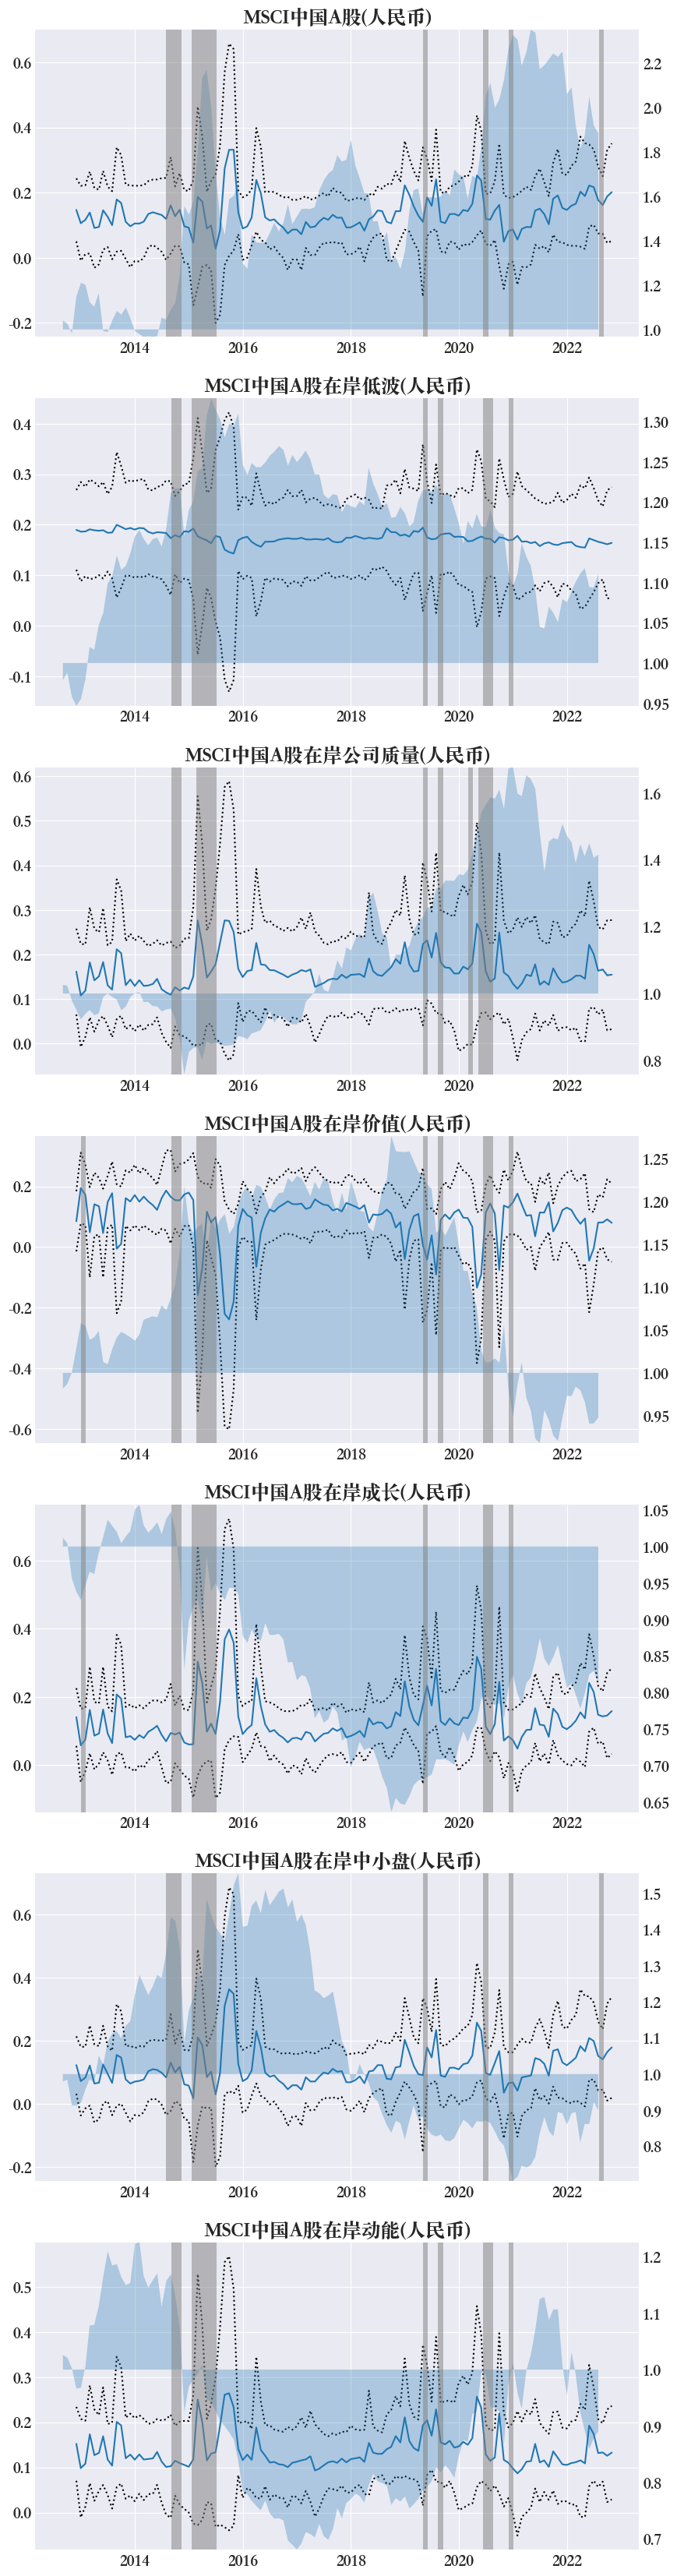

In [614]:
month_interval =(trace_alpha_total_infl.observed_data.date).astype('datetime64[ns]')[3]-(trace_alpha_total_infl.observed_data.date).astype('datetime64[ns]')[0]

fig,ax =plt.subplots(fund_dim,1,figsize=(10,fund_dim*6))

SR_t_mean_fig=ppc_pred.predictions.stack()["SR_t"].mean(axis=2)
SR_t_std_fig=ppc_pred.predictions.stack()["SR_t"].std(axis=2)



TT_figure_predict=(ppc_pred.observed_data.date).astype('datetime64[ns]')+month_interval
TT_figure=(ppc_pred.observed_data.date).astype('datetime64[ns]')
data_fund=np.exp((Df_Factor/12).T.cumsum())
for i in range(fund_dim):
  
    idx=SR_t_std_fig[i]>np.quantile(SR_t_std_fig[i],0.95)
   
    
    ax[i].plot(TT_figure_predict,SR_t_mean_fig[i]+1*SR_t_std_fig[i],':',color="k")
    ax[i].plot(TT_figure_predict,SR_t_mean_fig[i])
    #ax[i].fill_between(TT_figure_predict,T_vol,0,alpha=0.3,color="r")
    
    ax[i].plot(TT_figure_predict,SR_t_mean_fig[i]-1*SR_t_std_fig[i],':',color="k")
    
     
    ax[i].set_title(Df_Factor.index.values[i])
    ax[i].grid()
    #ax[i].set_ylim([-2,2])
    
    ax_right = ax[i].twinx()
    
    #__drawdown =(draw_down_price[i] - draw_down_price[i+"_max"])/draw_down_price[i+"_max"]
    #print(__drawdown)
    ax_right.fill_between(TT_figure,data_fund[Df_Factor.index.values[i]],1,alpha=0.3)
    ax_right.set_ylim([data_fund[Df_Factor.index.values[i]].min(),data_fund[Df_Factor.index.values[i]].max()])
  
    #x_low=TT_figure[idx]-month_interval/3
    #x_high=TT_figure[idx]+month_interval/3
    
    #(TT_figure[idx][1:].values-TT_figure[idx][:-1].values)/2678400000000000
    
    
    betas =-SR_t_std_fig[i]
    threshold=-np.quantile(SR_t_std_fig[i],0.9)
    regimelist=regime_switch(betas,threshold)
    curr_reg = np.sign(betas[0]-threshold)
    for m in range(len(regimelist)-1):
        if curr_reg == 1:
            pass
            # uncomment below if we want to color the normal regimes
            #ax.axhspan(0, data.max(), xmin=regimelist[i]/regimelist[-1], xmax=regimelist[i+1]/regimelist[-1], 
             #         facecolor="green", alpha=0.3)
        else:
            ax_right.axhspan(0, data_fund[Df_Factor.index.values[i]].max(),  xmin=regimelist[m]/regimelist[-1], xmax=regimelist[m+1]/regimelist[-1], 
                       facecolor='gray', alpha=0.5)
        curr_reg = -1 * curr_reg
        
    
  
    
    
    #ax_right.fill_between(TT_figure[T_vol==2],data_fund[Df_Factor.index.values[i]][T_vol==2],1,alpha=0.6)
    

In [615]:
ppc_pred_r.observed_data["_IC"].values.std(axis=1)

array([0.8455467 , 1.11655285, 0.90066765, 0.59049478, 0.81759459,
       0.77185607, 0.86804142, 0.87618074, 0.86428179, 0.95921491])

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

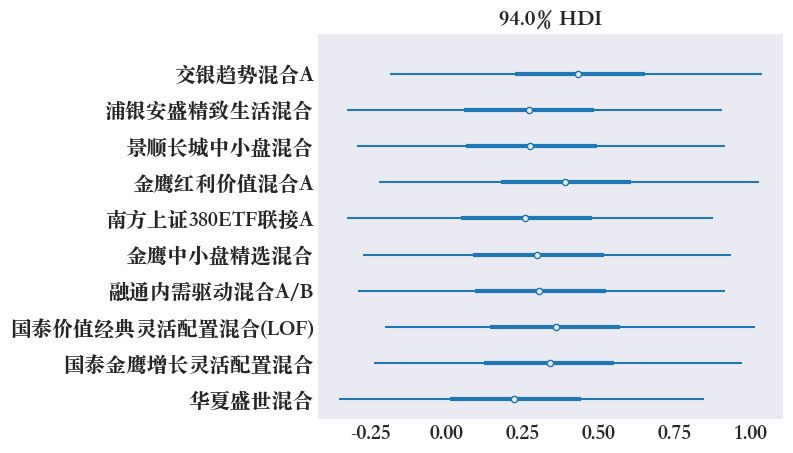

In [616]:
 az.plot_forest(
    trace_alpha_total_bm,
    var_names=["IC_alpha"],
    #kind="ridgeplot",
    combined=True,
    coords={"Alpha":__Df_alpha_model.index.values},
    labeller=az.labels.NoVarLabeller(),
)
    

In [268]:
#az.extract(trace_alpha_total_bm,group="posterior_predictive", var_names="_IC", combined=True).std(axis=2).T.to_dataframe()["_IC"].unstack()


# 配置资产配置回撤模块（数据模块）

## 回撤收益数据

In [617]:

data_predict_r=pd.concat([Df_Factor,__Df_alpha_model]).T

## 相关系数

In [618]:


correlation = pd.concat([Df_Factor,__Df_alpha_model]).T.corr()
correlation.style.background_gradient(cmap=cm).format("{:.2f}", na_rep='MISS')

,MSCI中国A股(人民币),MSCI中国A股在岸低波(人民币),MSCI中国A股在岸公司质量(人民币),MSCI中国A股在岸价值(人民币),MSCI中国A股在岸成长(人民币),MSCI中国A股在岸中小盘(人民币),MSCI中国A股在岸动能(人民币),交银趋势混合A,浦银安盛精致生活混合,景顺长城中小盘混合,金鹰红利价值混合A,南方上证380ETF联接A,金鹰中小盘精选混合,融通内需驱动混合A/B,国泰价值经典灵活配置混合(LOF),国泰金鹰增长灵活配置混合,华夏盛世混合
MSCI中国A股(人民币),1.00,-0.00,-0.05,0.02,-0.02,-0.01,-0.08,0.72,0.57,0.66,0.58,0.87,0.64,0.73,0.78,0.70,0.78
MSCI中国A股在岸低波(人民币),-0.00,1.00,0.39,-0.02,0.30,0.49,0.09,0.24,0.18,0.33,0.08,0.27,0.23,0.17,0.20,0.31,0.09
MSCI中国A股在岸公司质量(人民币),-0.05,0.39,1.00,-0.70,0.62,0.18,0.43,0.17,0.18,0.21,-0.12,0.05,0.09,0.02,0.12,0.21,0.06
MSCI中国A股在岸价值(人民币),0.02,-0.02,-0.70,1.00,-0.81,-0.24,-0.66,-0.21,-0.38,-0.22,0.00,-0.10,-0.21,-0.13,-0.17,-0.23,-0.26
MSCI中国A股在岸成长(人民币),-0.02,0.30,0.62,-0.81,1.00,0.71,0.63,0.36,0.58,0.49,0.21,0.31,0.49,0.27,0.35,0.46,0.43
MSCI中国A股在岸中小盘(人民币),-0.01,0.49,0.18,-0.24,0.71,1.00,0.28,0.42,0.55,0.59,0.45,0.46,0.63,0.38,0.43,0.53,0.47
MSCI中国A股在岸动能(人民币),-0.08,0.09,0.43,-0.66,0.63,0.28,1.00,0.15,0.32,0.17,0.00,0.08,0.21,0.05,0.06,0.17,0.18
交银趋势混合A,0.72,0.24,0.17,-0.21,0.36,0.42,0.15,1.00,0.73,0.82,0.66,0.85,0.77,0.77,0.81,0.79,0.81
浦银安盛精致生活混合,0.57,0.18,0.18,-0.38,0.58,0.55,0.32,0.73,1.00,0.78,0.59,0.74,0.75,0.71,0.75,0.80,0.78
景顺长城中小盘混合,0.66,0.33,0.21,-0.22,0.49,0.59,0.17,0.82,0.78,1.00,0.67,0.86,0.88,0.80,0.86,0.89,0.83


## 经典收益计算规则

In [619]:
###指数与风格的收益率、方差（滚动36个月回归）
df_ret_ratio_mean_yearly=(index_adj.resample("M").sum()*12).rolling(36).mean()
###波动率计算规则方法1:
df_ret_ratio_std_yearly=(np.sqrt((index_adj**2).resample("M").sum())*np.sqrt(12)).rolling(36).mean()
###波动率计算规则方法2:
((index_adj.resample("M").sum()*12).rolling(36).std()/np.sqrt(12)).mean()

###fund的收益率与波动率计算
data_alpha_mean_yearly=(data_alpha_filter*12).rolling(36).mean()
data_alpha_std_yearly=(data_alpha_filter*12).rolling(36).std()/np.sqrt(12)



In [620]:
df_data_r_backtest = pd.DataFrame(columns = ["Period"]).set_index("Period")
df_data_r_backtest.index=pd.date_range(start="2012-09-01",end="2022-09-01",freq="M").to_period("M")
df_data_r_backtest["Test_"] = "True"



df_data_r_backtest_mean = pd.concat([df_data_r_backtest,df_ret_ratio_mean_yearly,data_alpha_mean_yearly],axis=1).query('Test_=="True"')
df_data_r_backtest_std = pd.concat([df_data_r_backtest,df_ret_ratio_std_yearly,data_alpha_std_yearly],axis=1).query('Test_=="True"')




df_data_r_backtest_mean1 = df_data_r_backtest_mean.drop("Test_",axis=1).T
df_data_r_backtest_std1 = df_data_r_backtest_std.drop("Test_",axis=1).T

In [621]:
df_data_r_backtest_mean1.T.mean()

MSCI中国A股(人民币)          0.043486
MSCI中国A股在岸低波(人民币)      0.012255
MSCI中国A股在岸公司质量(人民币)    0.042952
MSCI中国A股在岸价值(人民币)     -0.001882
MSCI中国A股在岸成长(人民币)     -0.024636
MSCI中国A股在岸中小盘(人民币)    -0.020459
MSCI中国A股在岸动能(人民币)     -0.013331
交银趋势混合A                0.220640
浦银安盛精致生活混合             0.139454
景顺长城中小盘混合              0.111998
金鹰红利价值混合A              0.117905
南方上证380ETF联接A          0.073597
金鹰中小盘精选混合              0.116857
融通内需驱动混合A/B            0.120513
国泰价值经典灵活配置混合(LOF)      0.168470
国泰金鹰增长灵活配置混合           0.145513
华夏盛世混合                 0.044050
dtype: float64

In [622]:
df_data_r_backtest_std1.T.mean()

MSCI中国A股(人民币)          0.200323
MSCI中国A股在岸低波(人民币)      0.050285
MSCI中国A股在岸公司质量(人民币)    0.094102
MSCI中国A股在岸价值(人民币)      0.046326
MSCI中国A股在岸成长(人民币)      0.077865
MSCI中国A股在岸中小盘(人民币)     0.127069
MSCI中国A股在岸动能(人民币)      0.098187
交银趋势混合A                0.255001
浦银安盛精致生活混合             0.322716
景顺长城中小盘混合              0.257677
金鹰红利价值混合A              0.161461
南方上证380ETF联接A          0.237307
金鹰中小盘精选混合              0.220082
融通内需驱动混合A/B            0.259329
国泰价值经典灵活配置混合(LOF)      0.251913
国泰金鹰增长灵活配置混合           0.246171
华夏盛世混合                 0.285355
dtype: float64

In [623]:
data_obs_std.index.astype('datetime64[ns]').to_period("M")

PeriodIndex(['2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02',
             '2013-03', '2013-04', '2013-05', '2013-06',
             ...
             '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04',
             '2022-05', '2022-06', '2022-07', '2022-08'],
            dtype='period[M]', name='date', length=120)

## 贝叶斯后验的均值和方差


In [624]:
###指数与风格的收益率、
data_obs_mean=az.extract(ppc_pred_r,group="predictions", var_names="obs", combined=False).mean(axis=2).T.to_dataframe()["obs"].unstack()
data_obs_mean.index =data_obs_mean.index.astype('datetime64[ns]').to_period("M")

###指数与风格的标准差
data_obs_std=np.sqrt(12)*(az.extract(ppc_pred_r,group="predictions", var_names="obs", combined=False)/12).std(axis=2).T.to_dataframe()["obs"].unstack()
data_obs_std.index =data_obs_std.index.astype('datetime64[ns]').to_period("M")


###基金的的后验收益率、
data_IC_mean=az.extract(ppc_pred_r,group="predictions", var_names="_IC", combined=False).mean(axis=2).T.to_dataframe()["_IC"].unstack()
data_IC_mean.index =data_IC_mean.index.astype('datetime64[ns]').to_period("M")

###基金的后验标准差
data_IC_std=np.sqrt(12)*(az.extract(ppc_pred_r,group="predictions", var_names="_IC", combined=False)/12).std(axis=2).T.to_dataframe()["_IC"].unstack()
data_IC_std.index =data_IC_std.index.astype('datetime64[ns]').to_period("M")


In [625]:
df_data_r_backtest = pd.DataFrame(columns = ["Period"]).set_index("Period")
df_data_r_backtest.index=pd.date_range(start="2012-09-01",end="2022-09-01",freq="M").to_period("M")
df_data_r_backtest["Test_"] = "True"



df_data_r_backtest_mean = pd.concat([df_data_r_backtest,data_obs_mean,data_IC_mean],axis=1).query('Test_=="True"')
df_data_r_backtest_std = pd.concat([df_data_r_backtest,data_obs_std,data_IC_std],axis=1).query('Test_=="True"')




df_data_r_backtest_mean2 = df_data_r_backtest_mean.drop("Test_",axis=1).T
df_data_r_backtest_std2 = df_data_r_backtest_std.drop("Test_",axis=1).T

In [627]:
#df_data_r_backtest_mean2.loc["MSCI中国A股在岸价值(人民币)"].plot()

In [629]:
#df_data_r_backtest_mean1.loc["MSCI中国A股在岸价值(人民币)"].plot()

In [630]:
#df_data_r_backtest_std2.T.mean()

# 配置资产均值方差模块

In [631]:
import sys
sys.path.append("/Users/xinyuexu/Public/multi_asset/编程学习/financial_course/finance-courses")
import edhec_risk_kit_FOF as erk

In [549]:
#erk.summary_stats(pd.DataFrame(T_total)["2013":]).style.background_gradient(cmap=cm).format("{:.3f}", na_rep='MISS')

In [632]:

def weight_minvar(ret,cov):
    '''
    Produces the weights of the Minimum Volatility Portfolio given a covariance matrix of the returns 
    '''
    return erk.minimize_volatility(ret, cov)

def weight_maxsharpe(ret,cov, periods_per_year=1, risk_free_rate=0):
    '''
    Produces the weights of the Maximum Sharpe Ratio Portfolio given a covariance matrix of the returns 
    '''
    est_cov = cov
   
    ann_ret=np.squeeze(ret)
    return erk.maximize_shape_ratio_robust(ann_ret, est_cov, risk_free_rate=risk_free_rate, periods_per_year=periods_per_year)



def weight_ew(ret,cov, cap_ws=None, max_cw_mult=None, microcap_thr=None, **kwargs):
    """
    Returns the weights of the Equally-Weighted (EW) portfolio based on the asset returns "r" as a DataFrame. 
    If the set of cap_ws is given, the modified scheme is computed, i.e., 
    microcaps are removed and a capweight tether applied.
    """
    r =ret.T
    ew = pd.Series(1/len(r.columns), index=r.columns)
    if cap_ws is not None:
        cw = cap_ws.loc[r.index[0]] # starting cap weight
        if microcap_thr is not None and microcap_thr > 0.0:
            # exclude microcaps according to the threshold    
            ew[ cw < microcap_thr ] = 0
            ew = ew / ew.sum()
        if max_cw_mult is not None and max_cw_mult > 0:
            # limit weight up to a multiple of capweight
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew / ew.sum()
    return ew







def backtest_weight_scheme(r,Ret,Std,window=36,weight_scheme=weight_ew, **kwargs):
    '''
    Backtests a given weighting scheme. Here:
    - r: asset returns to use to build the portfolio
    - window: the rolling window used
    - weight_scheme: the weighting scheme to use, it must the name of a 
    method that takes "r", and a variable number of keyword-value arguments
    '''
    n_periods = r.shape[0]
    windows = [ (start, start+window) for start in range(0,n_periods-window) ]
    weights=[]
    
    
    for win in windows: 
        
        index=win[1]
        ret =Ret.iloc[[index]].T
        ret_sd = np.expand_dims(Std.iloc[index].values, axis=1)  
        cov = ret_sd.dot(ret_sd.T)*correlation  
        weight = weight_scheme(ret,cov,**kwargs)
        weights.append(weight)
        
    weights = pd.DataFrame(weights, index=r.iloc[window:].index, columns=r.columns)    
    returns = (weights * r).sum(axis=1,  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return weights,returns

In [384]:

# f,ax= plt.subplots(1,1,figsize=(20,12))
# T_total ={}
# for i in weight_ALL.index:
    
#     T_return =(df_returns_ratio.replace(np.nan,0).dot(weight_ALL.loc[i])+1).cumprod()
#     ax.plot(((df_returns_ratio.replace(np.nan,0).dot(weight_ALL.loc[i])+1).cumprod()),label=i)
#     T_total[i]=((df_returns_ratio.replace(np.nan,0).dot(weight_ALL.loc[i])))
# ax.legend(loc=2)

In [633]:
Ret2 = df_data_r_backtest_mean2.T
Ret1 = df_data_r_backtest_mean1.T

<AxesSubplot: >

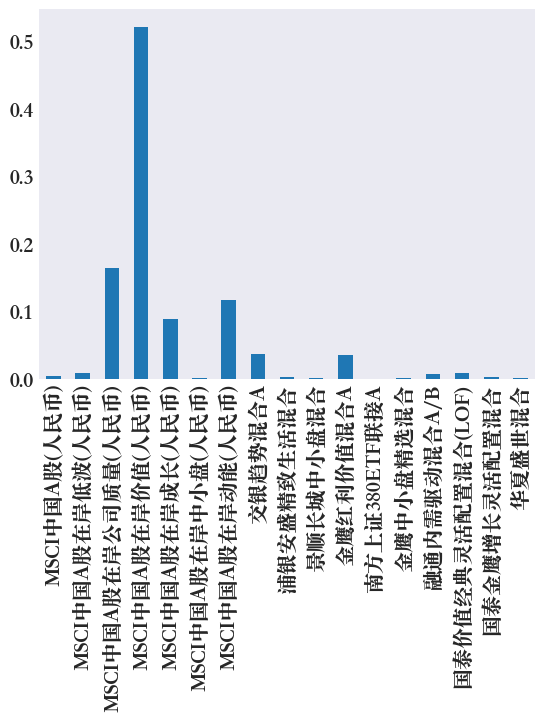

In [634]:
weight_ALL={}

r_ALL={}

Ret = df_data_r_backtest_mean2.T
Std = df_data_r_backtest_std2.T
weights,returns = backtest_weight_scheme(data_predict_r,Ret,Std,window=36, weight_scheme=weight_ew)
weight_ALL["等权重"]= weights
r_ALL["等权重"]= returns
#weights,returns = backtest_weight_scheme(data_predict_r,Ret,Std,window=36, weight_scheme=weight_minvar)
#weight_ALL["最小方差:贝叶斯后验"]= weights
#r_ALL["最小方差:贝叶斯后验分布"]= returns


weights,returns = backtest_weight_scheme(data_predict_r,Ret,Std,window=36, weight_scheme=weight_maxsharpe)
weight_ALL["最大夏普:贝叶斯后验"]= weights
r_ALL["最大夏普:贝叶斯后验分布"]= returns

weights.mean(axis=0).plot.bar()




In [636]:
Ret = df_data_r_backtest_mean1.T
Std = df_data_r_backtest_std1.T

#weights,returns = backtest_weight_scheme(data_predict_r,Ret,Std,window=36, weight_scheme=weight_minvar)
#weight_ALL["最小方差:传统滚动36个月分布"]= weights
#r_ALL["最小方差:传统滚动36个月分布"]= returns


weights,returns = backtest_weight_scheme(data_predict_r,Ret,Std,window=36, weight_scheme=weight_maxsharpe)
weight_ALL["最大夏普:传统滚动36个月分布"]= weights
r_ALL["最大夏普:传统滚动36个月分布"]= returns
#weights.mean(axis=0).plot.bar()
#np.exp(returns.cumsum()/12).plot()

<AxesSubplot: >

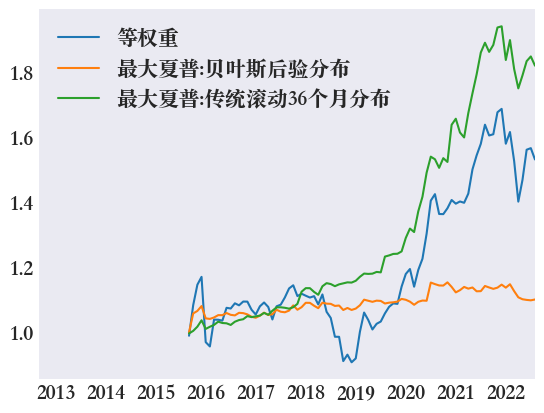

In [642]:
np.exp(pd.concat(r_ALL,axis=1).cumsum()/12).plot()

In [639]:
#weights.sum(axis=0).plot.bar()

In [641]:
#data_predict_r.mean(axis=1)

# 风格因子原序列与指数序列回归之后的序列比例关系

In [174]:
from WindPy import *

w.start()
w.isconnected()
from datetime import date
today_for_api  = str(date.today())
begin_for_api  = "2005-01-01"
import pandas as pd
data_code = pd.read_excel("/Users/xinyuexu/Public/multi_strategy/wind金融数据.xlsx",sheet_name="WSD_数据字段")
data_code = data_code.query("FOF研究==1")
name= data_code[["代码","名称"]].set_index("代码").to_dict()
str_code_=""
for i,j in enumerate(data_code["代码"]):
        
    if i >0:
        str_code_ = str_code_+","+str(j)
    else:
        str_code_ = str_code_+str(j)

        
error,df= w.edb(str_code_, begin_for_api, today_for_api, "Fill=Previous",usedf=True);
#error,_data_ = w.wsd(str_code_, "close", "2022-01-01", today_for_api, "PriceAdj=F",usedf=True);
df.index =pd.to_datetime(df.index,infer_datetime_format=True).to_period("D")

df=df.rename(columns=name["名称"])

df_ret_ratio=np.log(df)-np.log(df.shift(1))

df_ret_ratio_mean_monthly=df_ret_ratio.resample("M").sum()
df_ret_ratio_std_monthly=np.sqrt((df_ret_ratio**2).resample("M").sum())
df_sharpe =df_ret_ratio_mean_monthly/df_ret_ratio_std_monthly

df_sharpe.mean()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2021 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


MSCI中国A股(人民币)          0.150753
MSCI中国A股在岸低波(人民币)      0.161999
MSCI中国A股在岸公司质量(人民币)    0.189210
MSCI中国A股在岸价值(人民币)      0.155425
MSCI中国A股在岸成长(人民币)      0.187682
MSCI中国A股在岸中小盘(人民币)     0.217424
MSCI中国A股在岸动能(人民币)      0.104623
dtype: float64

In [175]:
from utility_data_deal import orthogonalized_factors
factor_adj,index_adj,beta=orthogonalized_factors(df_ret_ratio,df_ret_ratio.columns[0],df_ret_ratio.columns[1:])
df_ret_ratio= df_ret_ratio.dropna()

# 回归关系

In [278]:
df_data_predict = pd.DataFrame(columns = ["Period"]).set_index("Period")
date_model_predict =pd.date_range(start="2017-09-01",end="2022-09-01",freq="M").to_period("M")
df_data_predict.index=date_model_predict


# df_data["Test_"] = "True"



# df_macro_filter = pd.concat([df_data,macro_zscore.shift(3)],axis=1).query('Test_=="True"')
# df_macro_filter_predict = pd.concat([df_data,macro_zscore],axis=1).query('Test_=="True"')

# df_Factor_filter=pd.concat([df_data,index_transformer_month],axis=1).query('Test_=="True"')
# data_alpha_filter =pd.concat([df_data,df_fund],axis=1).query('Test_=="True"')
# data_alpha_filter= data_alpha_filter.dropna(axis=1)


